In [1]:
# This notebook produces a report for a water feature and the municipalities that
# have shoreline on the water feature. The aggregate of the survey area and all the
# data is included with all the charts except the monthly averages. This notebook is identical
# to the other notebooks for water features except for the locale setting and language output.
# This needs to be condensed to one class with a plot function for the different reports.
# contact analyst@hammerdirt.ch to contribute.

# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from PIL import Image as PILImage
from IPython.display import Markdown as md

# set some parameters:
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]
a_fail_rate = 50
unit_label = "p/100m"
a_color = "dodgerblue"

# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

# set the opening map image
bassin_map = PILImage.open("resources/maps/walensee_scaled.jpeg")

# top level aggregation
# label appears on charts
top = "All survey areas"

# define the feature level and components
# define the slug, name and aggregation level
this_feature = {'slug':'walensee', 'name':"Walensee", 'level':'water_name_slug'}

# these are the features that the report will be about
these_features = ["walensee"]

# define the component aggregation level
this_level = "city"

# this identifies the survey area to work in
# and defines a label for charting
this_bassin='linth'
bassin_label='Linth/Limmat'

# get the data:
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# map location slug to the proper city name
city_map = dfBeaches["city"]

# make any adjustments to code definitions here:
dfCodes.set_index("code", inplace=True)

# the surveyor designated the object as aluminum instead of metal
dfCodes.loc["G708", "material"] = "Metal"

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code materials
code_material_map = dfCodes.material

(walensee)=
# Walensee

*Map of survey locations April 2020 - May 2021*

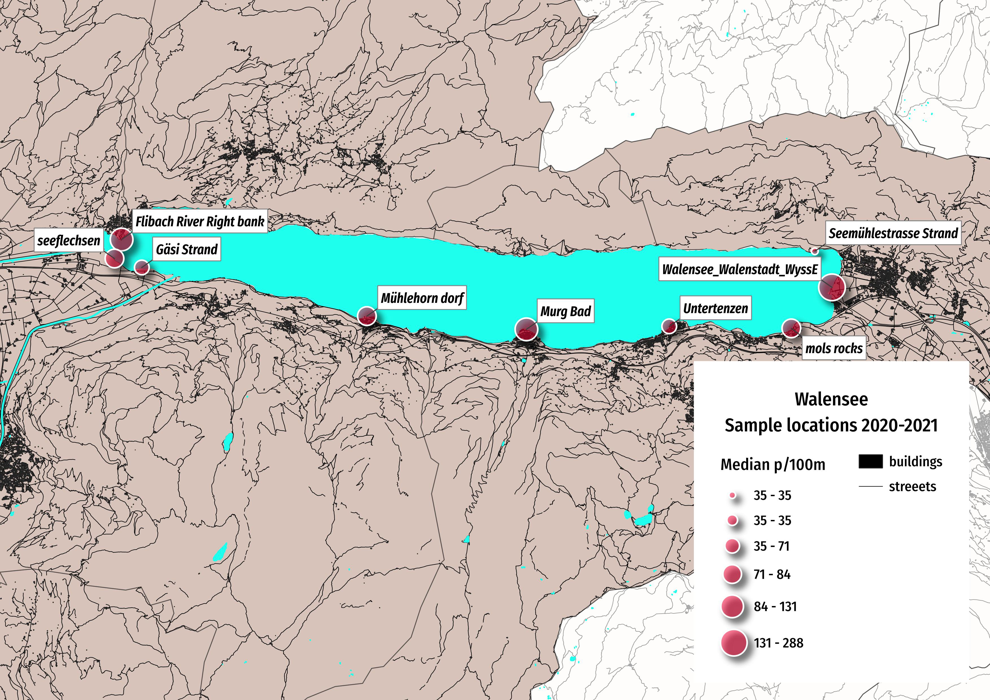

In [2]:
bassin_map.thumbnail((1200,700))
display(bassin_map)

## Sample locations

In [3]:
# common aggregations of survey data
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# aggregation of dimensional data
agg_dims = {"total_w":"sum", "mac_plast_w":"sum", "area":"sum", "length":"sum"}

# this is the data before the expanded fragmented plastics and foams are aggregated to Gfrags and Gfoams
# used to give the details of the gfrags and gfoam groups in the annex
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")

# this is the aggregated survey data that is being used
# a_data is all the data in the survey period
a_data = pd.read_csv(F"resources/checked_sdata_eos_2020_21.csv")
a_data["date"] = pd.to_datetime(a_data.date)

# fd is feature data. the data of interest
fd = sut.feature_data(a_data, this_feature["level"], these_features=these_features)
        
# cumulative statistics for each code
code_totals = sut.the_aggregated_object_values(fd, agg=agg_pcs_median, description_map=code_description_map, material_map=code_material_map)    
 
# daily survey totals
dt_all = fd.groupby(["loc_date","location",this_level, "date"], as_index=False).agg({unit_label:"sum","quantity":"sum"})

# the materials table
fd_mat_totals = sut.the_ratio_object_to_total(code_totals)

# summary statistics, nsamples, nmunicipalities, names of citys, population
t = sut.make_table_values(fd, col_nunique=["location", "loc_date", "city"], col_sum=["quantity"], col_median=[])

# make a map to the population values for each survey location/city
fd_pop_map = dfBeaches.loc[fd.location.unique()][["city", "population"]].copy()
fd_pop_map.drop_duplicates(inplace=True)

# update t with the population data
t.update(sut.make_table_values(fd_pop_map, col_nunique=["city"], col_sum=["population"], col_median=[]))

# update t with the list of locations from fd
t.update({"locations":fd.location.unique()})

# join the strings into comma separated list
obj_string = "{:,}".format(t["quantity"])
surv_string = "{:,}".format(t["loc_date"])
pop_string = "{:,}".format(int(t["population"]))

# make strings
date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, a total of {obj_string } objects were removed and identified over the course of {surv_string} surveys."
geo_context = F"The {this_feature['name']} results include {t['location']} different locations in {t['city']} different municipalities with a combined population of approximately {pop_string}."
munis_joined = ", ".join(sorted(fd_pop_map["city"]))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context }

*{this_feature["name"]} municipalities:*\n\n>{munis_joined}
"""
md(lake_string)


For the period between 2020-03 and 2021-05, a total of 3,694 objects were removed and identified over the course of 31 surveys. The Walensee results include 9 different locations in 4 different municipalities with a combined population of approximately 28,823.

*Walensee municipalities:*

>Glarus Nord, Quarten, Walenstadt, Weesen


### Cumulative totals by municipality

In [4]:
dims_parameters = dict(this_level=this_level, 
                       locations=fd.location.unique(), 
                       start_end=start_end, 
                       city_map=city_map, 
                       agg_dims=agg_dims)

dims_table = sut.gather_dimensional_data(dfDims, **dims_parameters)

# a map of total quantity for each component
q_map = fd.groupby(this_level).quantity.sum()

# assgin the quantity and sample numbers to the dims table
for name in dims_table.index:
    dims_table.loc[name, "samples"] = fd[fd[this_level] == name].loc_date.nunique()
    dims_table.loc[name, "quantity"] = q_map[name]

# make a total column for the top feature data, the sum of all the components
dims_table.loc[this_feature["name"]]= dims_table.sum(numeric_only=True, axis=0)

# change the column names to user friendly syle
dims_table.rename(columns=sut.update_dictionary(sut.dims_table_columns), inplace=True)

# format the numercial data
dims_table.sort_values(by=["items"], ascending=False, inplace=True)

# change to formatted strings
dims_table["plastic kg"] = dims_table["plastic kg"]/1000
dims_table[["m²", "meters", "samples", "items"]] = dims_table[["m²", "meters", "samples", "items"]].applymap(lambda x: "{:,}".format(int(x)))
dims_table[["plastic kg", "total kg"]] = dims_table[["plastic kg", "total kg"]].applymap(lambda x: "{:.2f}".format(x))

# figure caption
agg_caption = F"""
*__Below:__ The cumulative weights and measures for {this_feature["name"]} and municipalities*
"""
md(agg_caption)


*__Below:__ The cumulative weights and measures for Walensee and municipalities*


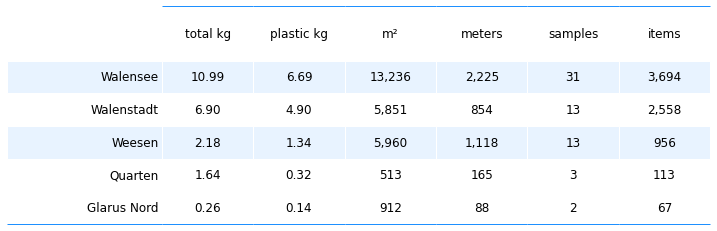

In [5]:
# make table
data = dims_table.reset_index()
colLabels = data.columns

fig, ax = plt.subplots(figsize=(len(colLabels)*1.8,len(data)*.8))

sut.hide_spines_ticks_grids(ax)
table_one = sut.make_a_table(ax, data.values, colLabels=colLabels, a_color=a_color)
table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

### Distribution of Survey results

In [6]:
# the feature surveys to chart
fd_dindex = dt_all.set_index("date")

# all the other surveys
ots = dict(level_to_exclude=this_feature["level"], components_to_exclude=fd[this_feature["level"]].unique())
dts_date = sut.the_other_surveys(a_data, **ots)

# group the outher surveys by date and total pcs_m
ots_params = dict(agg_this = {unit_label:"sum"}, these_columns = ["loc_date","date"])
dts_date = sut.group_these_columns(dts_date, **ots_params)

# get the monthly or quarterly results for the feature
resample_plot, rate = sut.quarterly_or_monthly_values(fd_dindex , this_feature["name"], vals=unit_label, quarterly=["ticino"])    

# scale the chart as needed to accomodate for extreme values
y_lim = 98
y_limit = np.percentile(dts_date[unit_label], y_lim)

# label for the chart that alerts to the scale
not_included = F"Values greater than {round(y_limit, 1)}{unit_label} not shown."

# figure caption
chart_notes = F"""
*__Left:__ {this_feature['name']}, {start_date[:7]} through {end_date[:7]}, n={t["loc_date"]}. {not_included} __Right:__ {this_feature['name']} empirical cumulative distribution of survey results.*
"""
md(chart_notes )


*__Left:__ Walensee, 2020-03 through 2021-05, n=31. Values greater than 2368.3p/100m not shown. __Right:__ Walensee empirical cumulative distribution of survey results.*


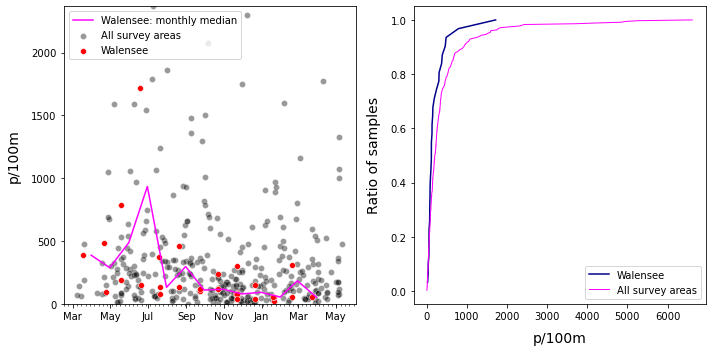

In [7]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
# months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

fig, axs = plt.subplots(1,2, figsize=(10,5))

# the survey totals by day
ax = axs[0]

# feature surveys
sns.scatterplot(data=dts_date, x=dts_date.index, y=unit_label, label=top, color="black", alpha=0.4,  ax=ax)
# all other surveys
sns.scatterplot(data=fd_dindex, x=fd_dindex.index, y=unit_label, label=this_feature["name"], color="red", s=34, ec="white", ax=ax)

# monthly or quaterly plot
sns.lineplot(data=resample_plot, x=resample_plot.index, y=resample_plot, label=F"{this_feature['name']}: {rate} median", color="magenta", ax=ax)

ax.set_ylim(0,y_limit )
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.legend()

# the cumlative distributions:
axtwo = axs[1]

# the feature of interest
feature_ecd = ECDF(dt_all[unit_label].values)    
sns.lineplot(x=feature_ecd.x, y=feature_ecd.y, color="darkblue", ax=axtwo, label=this_feature["name"])

# the other features
other_features = ECDF(dts_date[unit_label].values)
sns.lineplot(x=other_features.x, y=other_features.y, color="magenta", label=top, linewidth=1, ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Ratio of samples", **ck.xlab_k14)

plt.tight_layout()
plt.show()

### Summary data and material types

In [8]:
# figure caption
summary_of_survey_totals = F"""
*__Left:__ {this_feature['name']} summary of survey totals. __Right:__ {this_feature['name']} material type and percent of total*
"""
md(summary_of_survey_totals)


*__Left:__ Walensee summary of survey totals. __Right:__ Walensee material type and percent of total*


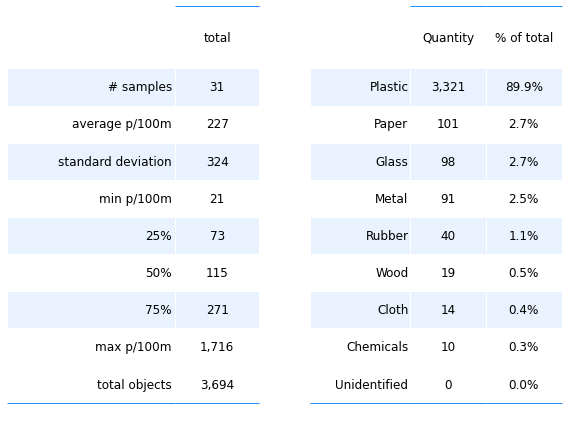

In [9]:
# get the basic statistics for the unit_label column from pd.describe
cs = dt_all[unit_label].describe().round(2)

# add project totals
cs["total objects"] = dt_all.quantity.sum()

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="EN"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])
    
fd_mat_totals = sut.fmt_pct_of_total(fd_mat_totals)
fd_mat_totals = sut.make_string_format(fd_mat_totals)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Quantity", "% of total":"% of total"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = [this_feature["name"], "total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

# data to use
data = fd_mat_t.copy()

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

## The most common objects

The most common objects are the **ten most abundant by quantity AND/OR objects identified in at least 50% of all surveys.**

In [10]:
# the top ten by quantity
most_abundant = code_totals.sort_values(by="quantity", ascending=False)[:10]

# the most common
most_common = code_totals[code_totals["fail rate"] >= a_fail_rate].sort_values(by="quantity", ascending=False)

# merge with most_common and drop duplicates
m_common = pd.concat([most_abundant, most_common]).drop_duplicates()

# get percent of total
m_common_percent_of_total = m_common.quantity.sum()/code_totals.quantity.sum()

# figure caption
rb_string = F"""
*__Below:__ {this_feature['name']} most common objects: fail rate >/= {a_fail_rate}%  and/or top ten by quantity. Combined, the most abundant objects represent {int(m_common_percent_of_total*100)}% of all objects found.*

Note : {unit_label} = median survey value.
"""
md(rb_string)


*__Below:__ Walensee most common objects: fail rate >/= 50%  and/or top ten by quantity. Combined, the most abundant objects represent 75% of all objects found.*

Note : p/100m = median survey value.


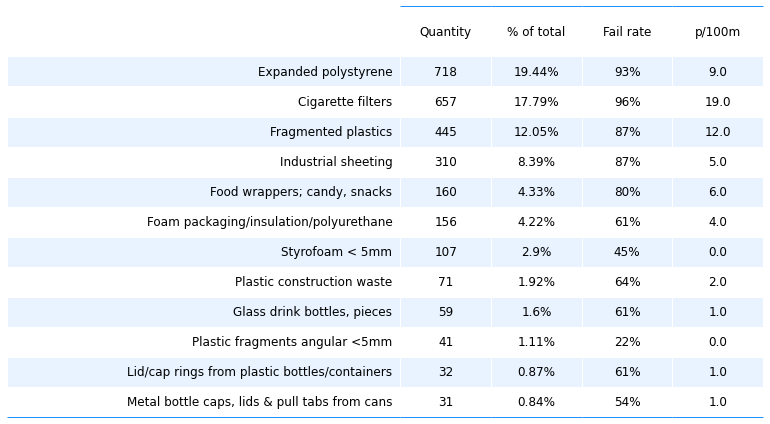

In [11]:
# format values for table
m_common["item"] = m_common.index.map(lambda x: code_description_map.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{x}%")
m_common["quantity"] = m_common.quantity.map(lambda x: "{:,}".format(x))
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: F"{round(x,1)}")

# final table data
cols_to_use = {"item":"Item","quantity":"Quantity", "% of total":"% of total", "fail rate":"Fail rate", unit_label:unit_label}
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(10.8,len(m_common)*.5))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.52, .12,.12,.12, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.show()

plt.close()

### Most common objects results by municipality

In [12]:
rb_string = F"""
*__Below:__ {this_feature['name']} most common objects: median {unit_label}*
"""
md(rb_string)


*__Below:__ Walensee most common objects: median p/100m*


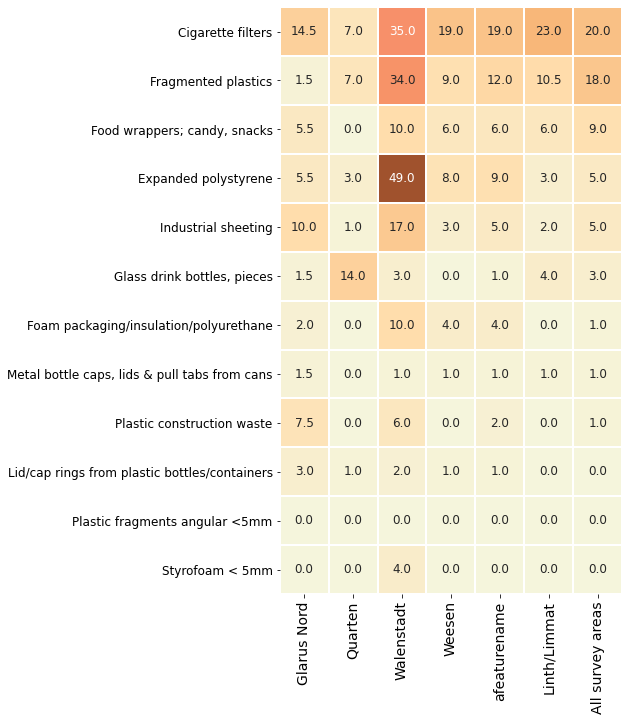

In [13]:
# aggregated survey totals for the most common codes for all the water features
# a common aggregation
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}

m_common_st = fd[fd.code.isin(m_common.index)].groupby([this_level, "loc_date", "code"], as_index=False).agg(agg_pcs_quantity)
m_common_ft = m_common_st.groupby([this_level, "code"], as_index=False)[unit_label].median()

# proper name of water feature for display
m_common_ft["f_name"] = m_common_ft["city"]

# map the desctiption to the code
m_common_ft["item"] = m_common_ft.code.map(lambda x: code_description_map.loc[x])

# pivot that
m_c_p = m_common_ft[["item", unit_label, "f_name"]].pivot(columns="f_name", index="item")

# quash the hierarchal column index
m_c_p.columns = m_c_p.columns.get_level_values(1)

# the aggregated totals for the feature:
f_s_x = fd[fd.code.isin(m_common.index)].groupby(["loc_date", "code"], as_index=False).agg(agg_pcs_quantity)
f_s_a_cols = sut.aggregate_to_code(f_s_x, code_description_map)

# the aggregated totals for the survey area
t_s_a = a_data[(a_data.code.isin(m_common.index))&(a_data.river_bassin == this_bassin)].groupby(["water_name_slug", "loc_date", "code"], as_index=False).agg(agg_pcs_quantity)
t_s_a_cols = sut.aggregate_to_code(t_s_a, code_description_map,name=bassin_label)

# repeat for all the survey areas
a_s_a = a_data[a_data.code.isin(m_common.index)].groupby(["water_name_slug", "loc_date", "code"], as_index=False).agg(agg_pcs_quantity)
a_s_a_cols = sut.aggregate_to_code(a_s_a, code_description_map,name=top)

# combine the columns
ad_t_ten = pd.concat([m_c_p, f_s_a_cols, t_s_a_cols, a_s_a_cols], axis=1).sort_values(by=top, ascending=False)

# chart that
fig, ax  = plt.subplots(figsize=(len(ad_t_ten.columns)*.9,len(ad_t_ten)*.9))
axone = ax

sns.heatmap(ad_t_ten, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".1f", square=True, cbar=False, linewidth=.1, linecolor="white")

axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="x", rotation=90)
axone.tick_params(labelsize=12, which="both", axis="y")
plt.show()
plt.close()

### Most common objects monthly average

In [14]:
# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(["loc_date", "date", "code", "groupname"], as_index=False).agg(agg_pcs_quantity)
m_common_m.set_index("date", inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code", "groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

monthly_mc = F"""
*__Below:__ {this_feature['name']}, monthly average survey result {unit_label}. Detail of the most common objects*
"""
md(monthly_mc)


*__Below:__ Walensee, monthly average survey result p/100m. Detail of the most common objects*


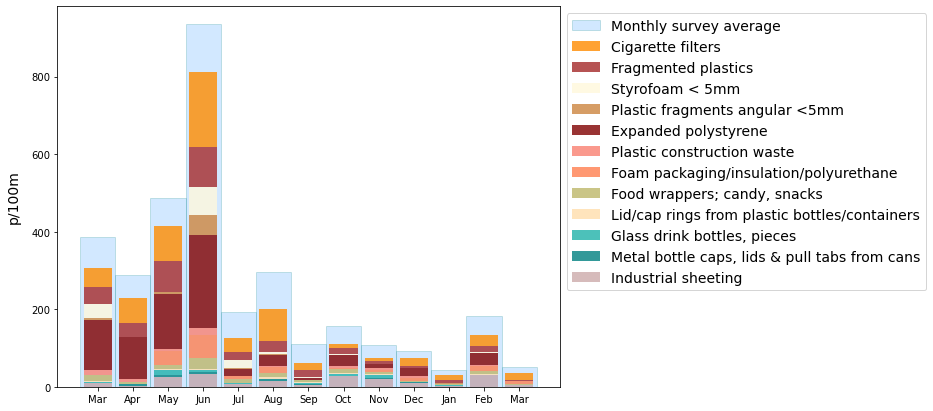

In [15]:
# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month
months={
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sep',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}

fig, ax = plt.subplots(figsize=(9,7))

# define a bottom
bottom = [0]*len(mgr["G27"])

# the monhtly survey average for all objects and locations
monthly_fd = fd.groupby(["loc_date", "date"], as_index=False).agg(agg_pcs_quantity)
monthly_fd.set_index("date", inplace=True)
m_fd = monthly_fd[unit_label].resample("M").mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color=a_color, alpha=0.2, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

#label the xticks by month
axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

ax.set_ylabel(unit_label, **ck.xlab_k14)

# make the legend
# swap out codes for descriptions
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Monthly survey average")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

## Utility of the objects found

The utility type is based on the utilization of the object prior to it being discarded or object description if the original use is undetermined. Identified objects are classified into one of 260 predefined categories. The categories are grouped according to utilization or item description. 

*  **wastewater**: items released from water treatment plants includes items likely toilet flushed   
*  **micro plastics (< 5mm)**: fragmented plastics and pre-production plastic resins 
*  **infrastructure**: items related to construction and maintenance of buildings, roads and water/power supplies 
*  **food and drink**: all materials related to consuming food and drink
*  **agriculture**: primarily industrial sheeting i.e., mulch and row covers, greenhouses, soil fumigation, bale wraps. Includes hard plastics for agricultural fencing, flowerpots etc. 
*  **tobacco**: primarily cigarette filters, includes all smoking related material 
*  **recreation**: objects related to sports and leisure i.e., fishing, hunting, hiking etc.
*  **packaging non food and drink**: packaging material not identified as food, drink nor tobacco related 
*  **plastic fragments**: plastic pieces of undetermined origin or use 
*  **personal items**: accessories, hygiene and clothing related 

See the annex for the complete list of objects identified, includes descriptions and group classification. The section [Code groups](codegroups) describes each code group in detail and provides a comprehensive list of all objects in a group.

In [16]:
cg_poft = F"""
<br></br>
*__Below:__ {this_feature['name']} utility of objects found % of total by municipality. Fragmented objects with no clear identification remain classified by size:*
"""
md(cg_poft)


<br></br>
*__Below:__ Walensee utility of objects found % of total by municipality. Fragmented objects with no clear identification remain classified by size:*


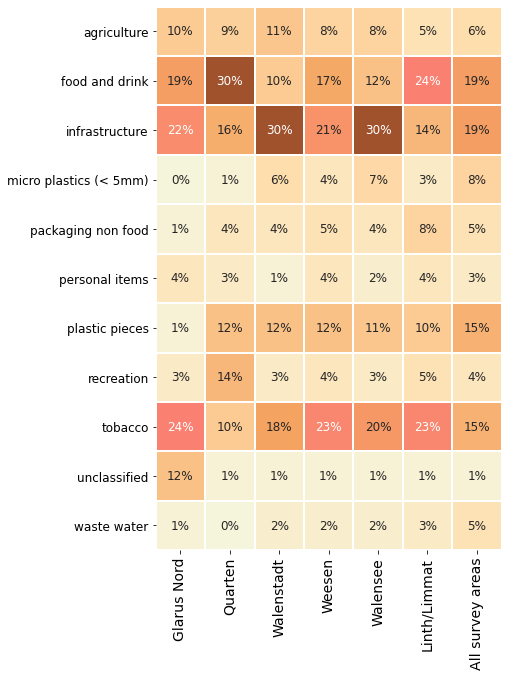

In [17]:
# code groups resluts aggregated by survey
groups = ["loc_date","groupname"]
cg_t = fd.groupby([this_level,*groups], as_index=False).agg(agg_pcs_quantity)

# get the fail rates for each group per survey
cg_t["fail"]=False
cg_t["fail"] = cg_t.quantity.where(lambda x: x == 0, True)

# aggregate all that for each municipality
agg_this = {unit_label:"median", "quantity":"sum", "fail":"sum", "loc_date":"nunique"} 
cg_t = cg_t.groupby([this_level, "groupname"], as_index=False).agg(agg_this)

# the total per municipality
cg_tq = cg_t.groupby(this_level).quantity.sum()

# assign the municipal total to the corresponding record
for a_feature in cg_tq.index:
    cg_t.loc[cg_t[this_level] == a_feature, "f_total"] = cg_tq.loc[a_feature]

# get the percent of total for each group for each municipality
cg_t["pt"] = (cg_t.quantity/cg_t.f_total).round(2)

# pivot that
data_table = cg_t.pivot(columns=this_level, index="groupname", values="pt")

# the aggregated totals for the feature
f_s_x = fd.groupby(groups, as_index=False).agg(agg_pcs_quantity)
f_s_a_cols = sut.aggregate_to_group_name(f_s_x, unit_label=unit_label, column="groupname", name=this_feature["name"], val="pt")

# repeat for the survey area
t_s_a = a_data[(a_data.river_bassin == this_bassin)].groupby(groups, as_index=False).agg(agg_pcs_quantity)
t_s_a_cols = sut.aggregate_to_group_name(t_s_a, unit_label=unit_label, column="groupname", name=bassin_label, val="pt")

# repeat for all the data
a_s_a = a_data.groupby(["water_name_slug", *groups], as_index=False).agg(agg_pcs_quantity)
a_s_a_cols = sut.aggregate_to_group_name(a_s_a, unit_label=unit_label, column="groupname", name=top, val="pt")

data = pd.concat([data_table,f_s_a_cols, t_s_a_cols, a_s_a_cols], axis=1)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, cbar=False, fmt=".0%", linewidth=.1, square=True, linecolor="white")

axone.set_ylabel("")

axone.tick_params(labelsize=14, which="both", axis="x", rotation=90)
axone.tick_params(labelsize=12, which="both", axis="y")

plt.show()

In [18]:
cg_medpcm = F"""
<br></br>
*__Below:__ {this_feature['name']} utility of objects found median {unit_label}. Fragmented objects with no clear identification remain classified by size:*
"""
md(cg_medpcm)


<br></br>
*__Below:__ Walensee utility of objects found median p/100m. Fragmented objects with no clear identification remain classified by size:*


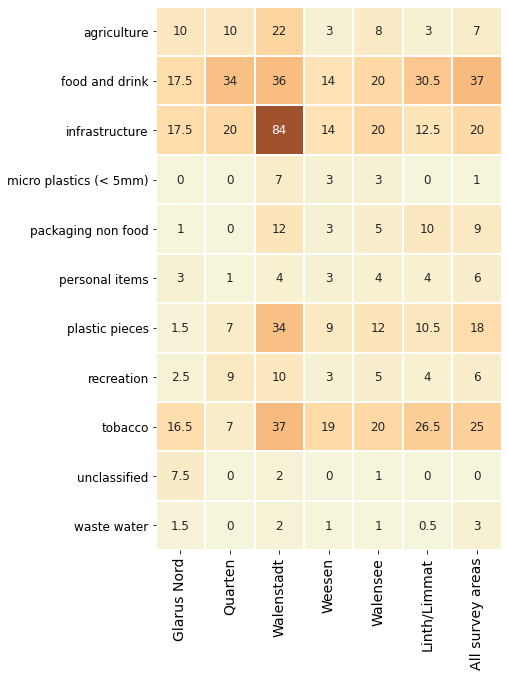

In [19]:
data_table = cg_t.pivot(columns=this_level, index="groupname", values=unit_label)

# the aggregated totals for the water feature
f_s_x = fd.groupby(groups, as_index=False).agg(agg_pcs_quantity)
f_s_a_cols = sut.aggregate_to_group_name(f_s_x, unit_label=unit_label, column="groupname", name=this_feature["name"], val="med")

# repeat for the survey area
t_s_a = a_data[(a_data.river_bassin == this_bassin)].groupby(groups, as_index=False).agg(agg_pcs_quantity)
t_s_a_cols = sut.aggregate_to_group_name(t_s_a, unit_label=unit_label, column="groupname", name=bassin_label, val="med")

# repeat for all the data
a_s_a = a_data.groupby(groups, as_index=False).agg(agg_pcs_quantity)
a_s_a_cols = sut.aggregate_to_group_name(a_s_a, unit_label=unit_label, column="groupname", name=top, val="med")

# merge with data_table
data = pd.concat([data_table, f_s_a_cols, t_s_a_cols , a_s_a_cols], axis=1)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt="g", cbar=False, linewidth=.1, square=True, linecolor="white")

axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="x",rotation=90)
axone.tick_params(labelsize=12, which="both", axis="y")

plt.show()

## Annex

### Fragmented foams and plastics by size

The table below contains the “Gfoam” and “Gfrags” components grouped for analysis. Objects labeled expanded foams are grouped as Gfoam and includes all expanded polystyrene foamed plastics > 0.5 cm.  Plastic pieces and objects made of combined plastic and foamed plastic materials > 0.5 cm. are grouped for analysis as Gfrags.

In [20]:
frag_foams = F"""
*__Below:__ {this_feature['name']} fragmented foams and plastics by size group.* 
"""
md(frag_foams)


*__Below:__ Walensee fragmented foams and plastics by size group.* 


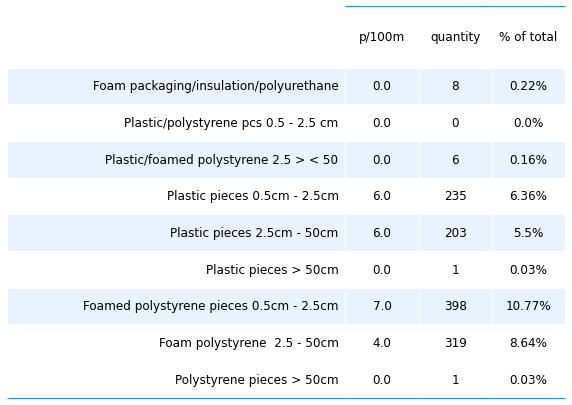

In [21]:
# collect the data before aggregating foams for all locations in the survey area
# the codes for the foams
some_foams = ["G81", "G82", "G83", "G74"]

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())

# aggregate all the codes by loc_date and get the total quantity and the median pcs/m
fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(t["locations"]))].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg({unit_label:"median", "quantity":"sum"})

# add code description and format for printing
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams["% of total"] = fd_frags_foams["% of total"].map(lambda x: F"{x}%")
fd_frags_foams["quantity"] = fd_frags_foams["quantity"].map(lambda x: F"{x:,}")

# table data
data = fd_frags_foams[["item", unit_label, "quantity", "% of total"]]

fig, axs = plt.subplots(figsize=(len(data.columns)*2.5,len(data)*.8))
sut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data.values,  colLabels=data.columns, colWidths=[.6, .13, .13, .13], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data.values,data.columns, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

### Organizations

1. Hammerdirt
2. Precious Plastic Leman

__The survey locations__

In [22]:
# display the survey locations

disp_columns = ["latitude", "longitude", "city"]
disp_beaches = dfBeaches.loc[t["locations"]][disp_columns]
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns={"slug":"location"}, inplace=True)
disp_beaches.set_index("location", inplace=True, drop=True)

disp_beaches

,latitude,longitude,city
location,,,
gasi-strand,47.128442,9.110831,Weesen
walensee_walenstadt_wysse,47.121828,9.299552,Walenstadt
untertenzen,47.115260,9.254780,Quarten
mols-rocks,47.114343,9.288174,Quarten
seeflechsen,47.130223,9.103400,Glarus Nord
seemuhlestrasse-strand,47.128640,9.295100,Walenstadt
muhlehorn-dorf,47.118448,9.172124,Glarus Nord
murg-bad,47.115307,9.215691,Quarten
flibach-river-right-bank,47.133742,9.105461,Weesen


### Inventory of items

In [23]:
pd.set_option("display.max_rows", None)

complete_inventory = code_totals[code_totals.quantity>0][["item", "groupname", "quantity","% of total","fail rate"]]
complete_inventory.sort_values(by="quantity", ascending=False)

,item,groupname,quantity,% of total,fail rate
code,,,,,
Gfoam,Expanded polystyrene,infrastructure,718,19.44,93
G27,Cigarette filters,tobacco,657,17.79,96
Gfrags,Fragmented plastics,plastic pieces,445,12.05,87
G67,Industrial sheeting,agriculture,310,8.39,87
G30,"Food wrappers; candy, snacks",food and drink,160,4.33,80
G74,Foam packaging/insulation/polyurethane,infrastructure,156,4.22,61
G117,Styrofoam < 5mm,micro plastics (< 5mm),107,2.90,45
G89,Plastic construction waste,infrastructure,71,1.92,64
G200,"Glass drink bottles, pieces",food and drink,59,1.60,61
